In [27]:
import pandas as pd
import numpy as np
from numpy.linalg import inv

import matplotlib.pyplot as plt

from tqdm import tqdm

In [10]:
dat = pd.read_csv('data/01_standard_practice.csv')

[[ 2.07188189e+02 -1.05427206e+00]
 [-1.05427206e+00  5.99181008e-03]]
==== fit report ====
  m = 1.08 +/- 0.08
  b = 213.27 +/- 14.39


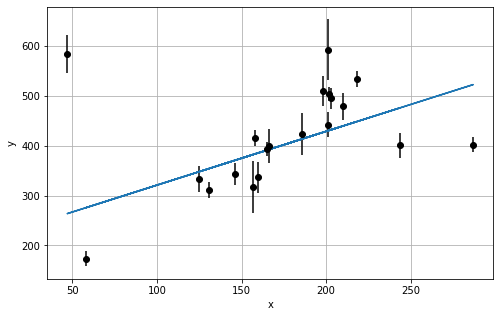

In [17]:
def linear(x,m,b):
    return m*x+b

def fit_standard(x, y, sig_y = None):
    #if sig_x is None:
    #    sig_x = np.zeros(len(x))
    #if sig_y is None:
    #    sig_y = np.zeros(len(y))
        
    A = np.array([[1, x[n]] for n in range(len(x))])
    C = np.diagflat(sig_y**2)
        
    cov = inv(A.T @ inv(C) @ A)
        
    X = cov @ ( A.T @ inv(C) @ y )
    
    return X, cov

x = np.array(dat['x'])
sig_x = np.array(dat['sig_x'])
y = np.array(dat['y'])
sig_y = np.array(dat['sig_y'])

X, cov = fit_standard(x, y, sig_y)

print(cov)

print('==== fit report ====\n  m = %2.2f +/- %2.2f\n  b = %2.2f +/- %2.2f' % (X[1], np.sqrt(cov[1][1]), X[0], np.sqrt(cov[0][0])))

plt.figure(figsize=(8,5))

plt.errorbar(x, y, yerr = sig_y, color = 'black', fmt = 'o')
plt.plot(x, linear(x, X[1], X[0]))

plt.xlabel('x')
plt.ylabel('y')
plt.grid()

In [18]:
import random

def bootstrap_linear(fitter, x, y, M, sig_y = None):        
    X_all, cov_all = fitter(x, y, sig_y)
    m = X_all[1]
    b = X_all[0]
    
    sig_m = 0
    sig_b = 0
    sig_mb = 0
        
    for i in range(M):
        tempx = []
        tempy = []
        tempsigy = []
        
        for j in range(len(x)):
            indx = random.randint(0,len(x)-1)
            
            tempx.append(x[indx])
            tempy.append(y[indx])
            tempsigy.append(sig_y[indx])
            
        X, cov = fitter(np.array(tempx), np.array(tempy), np.array(tempsigy))
        m_i = X[1]
        b_i = X[0]
        
        sig_m += (m_i - m)**2
        sig_b += (b_i - b)**2
        sig_mb += (m_i - m)*(b_i-b)
        
    cov = np.array([[sig_b / M, sig_mb / M],[sig_mb / M, sig_m / M]])
    return X_all, cov, cov_all

X, cov, cov_all = (bootstrap_linear(fit_standard, x, y, 15, sig_y))            
    
print('==== fit report ====\n  m = %2.2f +/- %2.2f (bootstrap: %2.2f)\n  b = %2.2f +/- %2.2f (bootstrap: %2.2f)' % (X[1], np.sqrt(cov_all[1][1]), np.sqrt(cov[1][1]), X[0], np.sqrt(cov_all[0][0]), np.sqrt(cov[0][0])))

==== fit report ====
  m = 1.08 +/- 0.08 (bootstrap: 0.69)
  b = 213.27 +/- 14.39 (bootstrap: 117.75)


In [20]:
def jackknife_linear(fitter, x, y, sig_y):
    X_all, cov_all = fitter(x, y, sig_y)
    m = X_all[1]
    b = X_all[0]
    
    N = len(x)
    
    m_list = []
    b_list = []
    
    for i in range(N):
        tempx = np.delete(x, i)
        tempy = np.delete(y, i)
        tempsigy = np.delete(sig_y, i)
                
        X, cov = fitter(tempx, tempy, tempsigy)
        
        m_list.append(X[1])
        b_list.append(X[0])
        
    m = (1 / len(m_list)) * sum(m_list)
    b = (1 / len(b_list)) * sum(b_list)
    
    sig_m = 0
    sig_b = 0
    sig_mb = 0
    
    for i in range(len(m_list)):
        sig_m += (m_list[i] - m)**2
        sig_b += (b_list[i] - b)**2
        sig_mb += (m_list[i] - m) * (b_list[i] - b)
    
    sig_m *= (N - 1) / N
    sig_b *= (N - 1) / N
    sig_mb *= (N - 1) / N
    
    cov = np.array([[sig_b, sig_mb],[sig_mb, sig_m]])
    return X_all, cov, cov_all

X, cov, cov_all = (jackknife_linear(fit_standard, x, y, sig_y))            

print('==== fit report ====\n  m = %2.2f +/- %2.2f (jackknife: %2.2f)\n  b = %2.2f +/- %2.2f (jackknife: %2.2f)' % (X[1], np.sqrt(cov_all[1][1]), np.sqrt(cov[1][1]), X[0], np.sqrt(cov_all[0][0]), np.sqrt(cov[0][0])))

    

==== fit report ====
  m = 1.08 +/- 0.08 (jackknife: 0.87)
  b = 213.27 +/- 14.39 (jackknife: 154.99)


In [24]:
import decimal

def linear(x, params):
    return params[0] * x + params[1]

def gaussian(y, sigma, mu):
    return ((1 / np.sqrt(2 * np.pi * sigma**2)) * np.exp( -(y - mu)**2 / (2 * sigma**2) ))

def likelihood(func, x, y, sig_y, params):
    '''
    Inputs:    
        y   - the dependent variable array of observed measurements
        m   - slope
        b   - intercept
        P_b - Probability of a bad point
        Y_b - mean of distribution of bad points
        V_b - variance of distribution of bad points
        sig_y - variance in y space
        
    Outputs:
        likelihood = p({y_i} | m, b, P_b, Y_b, V_b, I)
    '''
    
    m = params[0]
    b = params[1]
    P_b = params[2]
    Y_b = params[3]
    V_b = params[4]
    
    likelihood = 1
    
    for i in range(len(x)):        
        foreground = gaussian(y[i], sig_y[i], func(x[i], [m, b]))
        background = gaussian(y[i], np.sqrt(V_b + sig_y[i]**2), Y_b)
        #print(((1 - P_b) * foreground) + ((P_b) * background))
        
        likelihood *= ((1 - P_b) * foreground) + ((P_b) * background)
        
    return likelihood

In [25]:
import random
import pandas as pd

def metropolis_hastings(kernel, func, x, y, sig_y, params, steps = 5000, stepsize = 0.005):
    param_set = []
        
    param_array = []
    param_ub = []
    param_lb = []
        
    '''
    
    Initialize chain
    
    '''
        
    for key in params.keys():
        param_array.append(params[key][0])
        param_ub.append(params[key][1])
        param_lb.append(params[key][2])
        
    likelihood = kernel(func, x, y, sig_y, param_array)
    tarr = param_array.copy()
    tarr.append(likelihood)    
    param_set.append(tarr)
    
    #print(param_array)
    
    '''
    
    Start stepping
    
    '''
    
    for i in tqdm(range(steps)):
        #print(param_set)
        #print(param_array)
        prev_param_array = param_array
        prev_likelihood = param_set[-1][-1]
        
        for j in range(len(param_array)):
            newparam = random.gauss(prev_param_array[j], stepsize)
            if j in [2]:
                #print('bleh')
                #newparam = random.uniform(param_lb[j], param_ub[j])                
                while (newparam < 0) or (newparam > 1):
                    newparam = random.gauss(prev_param_array[j], stepsize)
                #print('blah')
            
            param_array[j] = newparam
            
        likelihood = kernel(func, x, y, sig_y, param_array)
        R = random.uniform(0, 1)
        
        if R < (likelihood / prev_likelihood):
            tarr = param_array.copy()
            tarr.append(likelihood)
            param_set.append(tarr)
        else:            
            tarr = prev_param_array.copy()
            tarr.append(prev_likelihood)
            param_set.append(tarr)
            
    columns = []
    for key in params.keys():
        columns.append(key)
    columns.append('likelihood')
            
    df = pd.DataFrame(np.array(param_set), columns = columns)
    
    return df

In [28]:
def get_params(kernel, func, x, y, sig_y, params, steps = 5000, stepsize = 0.005):
    df = metropolis_hastings(kernel, func, x, y, sig_y, params, steps, stepsize)
    
    m = np.mean(df['m'])
    b = np.mean(df['b'])
    
    return m, b, df



def bootstrap_mh(fitter, kernel, function, x, y, M, sig_y, params, steps = 5000, stepsize = 0.005):        
    m, b, df_all = fitter(kernel, function, x, y, sig_y, params, steps, stepsize)
    
    sig_m = 0
    sig_b = 0
    sig_mb = 0
        
    for i in range(M):
        tempx = []
        tempy = []
        tempsigy = []
        
        for j in range(len(x)):
            indx = random.randint(0,len(x)-1)
            
            tempx.append(x[indx])
            tempy.append(y[indx])
            tempsigy.append(sig_y[indx])
            
        m_i, b_i, df_i = fitter(kernel, function, x, y, sig_y, params, steps, stepsize)
        
        sig_m += (m_i - m)**2
        sig_b += (b_i - b)**2
        sig_mb += (m_i - m)*(b_i-b)
        
    cov = np.array([[sig_b / M, sig_mb / M],[sig_mb / M, sig_m / M]])
    return m, b, cov

params = {'m' : np.array([2, 0, 5]),
            'b' : np.array([30, 20, 40]),
            'P_b' : np.array([0.1, 0, 1]),
            'Y_b' : np.array([0, -100, 100]),
            'V_b' : np.array([10, -100, 100])}

m, b, cov = bootstrap_mh(get_params, likelihood, linear, x, y, 15, sig_y, params)

print('==== fit report ====\n  m = %2.2f +/- %2.2f\n  b = %2.2f +/- %2.2f' % (m, np.sqrt(cov[1][1]), b, np.sqrt(cov[0][0])))

100%|█████████████████████████████████████████████████████████████████████| 5000/5000 [00:02<00:00, 2474.98it/s]

==== fit report ====
  m = 2.07 +/- 0.20
  b = 30.50 +/- 0.57


In [29]:
def jackknife(fitter, kernel, function, x, y, sig_y, params, steps = 5000, stepsize = 0.005):        
    m, b, df_all = fitter(kernel, function, x, y, sig_y, params, steps, stepsize)    
    N = len(x)
    
    m_list = []
    b_list = []
    
    for i in range(N):
        tempx = np.delete(x, i)
        tempy = np.delete(y, i)
        tempsigy = np.delete(sig_y, i)
        
        m_i, b_i, df = fitter(kernel, function, x, y, sig_y, params, steps, stepsize)
        m_list.append(m_i)
        b_list.append(b_i)
        
    m = (1 / len(m_list)) * sum(m_list)
    b = (1 / len(b_list)) * sum(b_list)
    
    sig_m = 0
    sig_b = 0
    sig_mb = 0
    
    for i in range(len(m_list)):
        sig_m += (m_list[i] - m)**2
        sig_b += (b_list[i] - b)**2
        sig_mb += (m_list[i] - m) * (b_list[i] - b)
    
    sig_m *= (N - 1) / N
    sig_b *= (N - 1) / N
    sig_mb *= (N - 1) / N
    
    cov = np.array([[sig_b, sig_mb],[sig_mb, sig_m]])
    return m, b, cov

m, b, cov = jackknife(get_params, likelihood, linear, x, y, sig_y, params)

print('==== fit report ====\n  m = %2.2f +/- %2.2f\n  b = %2.2f +/- %2.2f' % (m, np.sqrt(cov[1][1]), b, np.sqrt(cov[0][0])))

100%|█████████████████████████████████████████████████████████████████████| 5000/5000 [00:02<00:00, 2405.34it/s]

==== fit report ====
  m = 1.99 +/- 0.85
  b = 30.01 +/- 1.04


In [35]:
df_1 = metropolis_hastings(likelihood, linear, x[5:], y[5:], sig_y[5:], params)
df_2 = metropolis_hastings(likelihood, linear, x[5:], y[5:], sig_y[5:]/2, params)

100%|█████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 3607.06it/s]


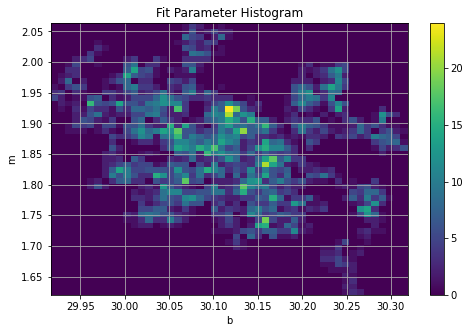

In [36]:
likelihoods = df_1['likelihood']
m = df_1['m']
b = df_1['b']

y_min = np.min(m)
y_max = np.max(m)

x_min = np.min(b)
x_max = np.max(b)

x_bins = np.linspace(x_min, x_max, 50)
y_bins = np.linspace(y_min, y_max, 50)

plt.figure(figsize=(8,5))

#plt.xlim(-100, 100)
#plt.ylim(1.5, 3)
plt.hist2d(b, m, bins =[x_bins, y_bins])
plt.title("Fit Parameter Histogram")

plt.xlabel('b')
plt.ylabel('m')
plt.grid()
plt.colorbar()

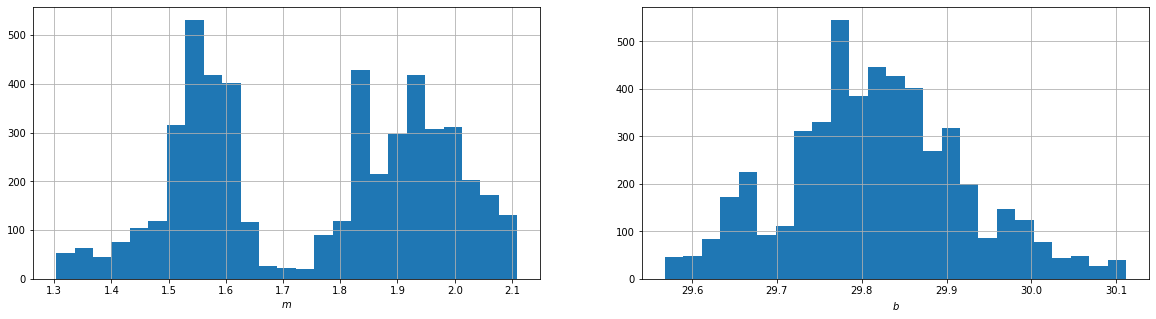

In [38]:
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
plt.hist(m, bins = 25)
#plt.title("Using Correct Data Uncertainties")
plt.xlabel(r'$m$')
plt.grid()

plt.subplot(1, 2, 2)
plt.hist(b, bins = 25)
#plt.title("Using Data Uncertainties / 2")
plt.xlabel(r'$b$')
plt.grid()

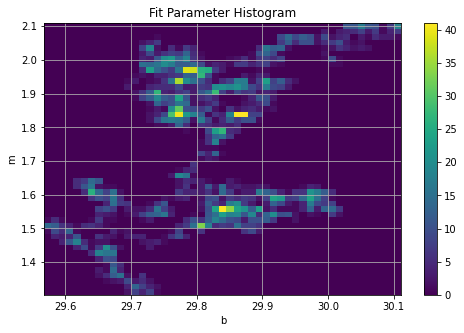

In [37]:
likelihoods = df_2['likelihood']
m = df_2['m']
b = df_2['b']

y_min = np.min(m)
y_max = np.max(m)

x_min = np.min(b)
x_max = np.max(b)

x_bins = np.linspace(x_min, x_max, 50)
y_bins = np.linspace(y_min, y_max, 50)

plt.figure(figsize=(8,5))

#plt.xlim(-100, 100)
#plt.ylim(1.5, 3)
plt.hist2d(b, m, bins =[x_bins, y_bins])
plt.title("Fit Parameter Histogram")

plt.xlabel('b')
plt.ylabel('m')
plt.grid()
plt.colorbar()

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
plt.hist(m, bins = 25)
#plt.title("Using Correct Data Uncertainties")
plt.xlabel(r'$m$')
plt.grid()

plt.subplot(1, 2, 2)
plt.hist(b, bins = 25)
#plt.title("Using Data Uncertainties / 2")
plt.xlabel(r'$b$')
plt.grid()